In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
%cd /content/drive/MyDrive/MyProject

/content/drive/MyDrive/MyProject


In [3]:
!pwd

/content/drive/MyDrive/MyProject


In [4]:
# verify GPU availability
import tensorflow as tf

device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


In [5]:
!nvidia-smi

Sat Apr 24 17:46:36 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 465.19.01    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   45C    P0    35W / 250W |    349MiB / 16280MiB |      4%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [6]:
import tensorflow as tf
print(tf.__version__)

2.4.1


In [7]:
from tensorflow.python.eager.context import eager_mode, graph_mode
import tensorflow.compat.v1 as tf
tf.enable_v2_behavior()
tf.compat.v1.enable_eager_execution()
tf.compat.v1.enable_v2_behavior()
tf.executing_eagerly()
tf.config.run_functions_eagerly(True)


In [8]:
# install huggingface Transformers
! pip install transformers


In [43]:
!pip install tqdm

In [9]:
import transformers
print(transformers.__version__)

4.5.1


In [41]:
from transformers import DistilBertTokenizerFast
from transformers import TFDistilBertForQuestionAnswering, TFTrainer, TFTrainingArguments, DistilBertConfig
from keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from keras.optimizers import Adam
from keras.losses import SparseCategoricalCrossentropy

import json
from pathlib import Path
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
% matplotlib inline


In [11]:
! pwd
%mkdir dataset

/content/drive/MyDrive/MyProject
mkdir: cannot create directory ‘dataset’: File exists


In [12]:
!wget https://rajpurkar.github.io/SQuAD-explorer/dataset/train-v2.0.json -O dataset/train-v2.0.json
!wget https://rajpurkar.github.io/SQuAD-explorer/dataset/dev-v2.0.json -O dataset/dev-v2.0.json

--2021-04-24 17:46:40--  https://rajpurkar.github.io/SQuAD-explorer/dataset/train-v2.0.json
Resolving rajpurkar.github.io (rajpurkar.github.io)... 185.199.108.153, 185.199.111.153, 185.199.110.153, ...
Connecting to rajpurkar.github.io (rajpurkar.github.io)|185.199.108.153|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 42123633 (40M) [application/json]
Saving to: ‘dataset/train-v2.0.json’

dataset/train-v2.0. 100%[===================>]  40.17M  60.2MB/s    in 0.7s    

2021-04-24 17:46:41 (60.2 MB/s) - ‘dataset/train-v2.0.json’ saved [42123633/42123633]

--2021-04-24 17:46:41--  https://rajpurkar.github.io/SQuAD-explorer/dataset/dev-v2.0.json
Resolving rajpurkar.github.io (rajpurkar.github.io)... 185.199.108.153, 185.199.111.153, 185.199.110.153, ...
Connecting to rajpurkar.github.io (rajpurkar.github.io)|185.199.108.153|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 4370528 (4.2M) [application/json]
Saving to: ‘dataset/dev-v2.0.jso

In [13]:
#function to read the train and dev (test) json data
#please open the JSON file to see what is teh format thats being used in the json file
#reading the data as per the format is important 

#Each split is in a structured json file with a number of questions and answers for each passage (or context). 

def read_squad(path):
    path = Path(path)
    with open(path, 'rb') as f:
        squad_dict = json.load(f)

    contexts = []
    questions = []
    answers = []
    for group in squad_dict['data']:
        for passage in group['paragraphs']:
            context = passage['context']
            for qa in passage['qas']:
                question = qa['question']
                for answer in qa['answers']:
                    contexts.append(context)
                    questions.append(question)
                    answers.append(answer)

    return contexts, questions, answers


In [14]:
#reading the train and dev json data

#The contexts and questions are just strings
#The answers are dicts containing the subsequence of the passage with the correct answer as well as an integer indicating the character at which the answer begins.

train_contexts, train_questions, train_answers = read_squad('dataset/train-v2.0.json')
val_contexts, val_questions, val_answers = read_squad('dataset/dev-v2.0.json')

In [15]:
#Since we already have the starting position for the answers...we need the character position where the answer is ending in the passage(context)

def add_end_idx(answers, contexts):
    for answer, context in zip(answers, contexts):
        gold_text = answer['text']
        start_idx = answer['answer_start']
        end_idx = start_idx + len(gold_text)

        # sometimes squad answers are off by a character or two – fix this
        if context[start_idx:end_idx] == gold_text:
            answer['answer_end'] = end_idx
        elif context[start_idx-1:end_idx-1] == gold_text:
            answer['answer_start'] = start_idx - 1
            answer['answer_end'] = end_idx - 1     # When the gold label is off by one character
        elif context[start_idx-2:end_idx-2] == gold_text:
            answer['answer_start'] = start_idx - 2
            answer['answer_end'] = end_idx - 2     # When the gold label is off by two characters

add_end_idx(train_answers, train_contexts)
add_end_idx(val_answers, val_contexts)



In [16]:
#Converting into a dataframe

examples = pd.DataFrame(
    {'contexts': train_contexts,
     'questions': train_questions
    })
answers=pd.DataFrame(train_answers)

In [17]:
final_data=pd.concat([examples,answers],axis=1)
final_data.head()


,contexts,questions,text,answer_start,answer_end
0,Beyoncé Giselle Knowles-Carter (/biːˈjɒnseɪ/ b...,When did Beyonce start becoming popular?,in the late 1990s,269,286
1,Beyoncé Giselle Knowles-Carter (/biːˈjɒnseɪ/ b...,What areas did Beyonce compete in when she was...,singing and dancing,207,226
2,Beyoncé Giselle Knowles-Carter (/biːˈjɒnseɪ/ b...,When did Beyonce leave Destiny's Child and bec...,2003,526,530
3,Beyoncé Giselle Knowles-Carter (/biːˈjɒnseɪ/ b...,In what city and state did Beyonce grow up?,"Houston, Texas",166,180
4,Beyoncé Giselle Knowles-Carter (/biːˈjɒnseɪ/ b...,In which decade did Beyonce become famous?,late 1990s,276,286


In [18]:
final_data.isnull().values.any() #checking if there is any null or nan values in our dataframe/dataset

False

In [19]:
#Tokenizing the context and questions pairs
#We need to send tokenized inputs to the model. 

tokenizer = DistilBertTokenizerFast.from_pretrained('distilbert-base-uncased')

train_encodings = tokenizer(train_contexts, train_questions, truncation=True, padding=True)
val_encodings = tokenizer(val_contexts, val_questions, truncation=True, padding=True)

In [20]:
print(type(train_encodings))

<class 'transformers.tokenization_utils_base.BatchEncoding'>


In [21]:
tokenizer("What is your name?", "My name is the Flash.")

{'input_ids': [101, 2054, 2003, 2115, 2171, 1029, 102, 2026, 2171, 2003, 1996, 5956, 1012, 102], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]}

In [22]:
#converting the character start/end positions to token start/end positions

def add_token_positions(encodings, answers):
    start_positions = []
    end_positions = []
    for i in range(len(answers)):
        start_positions.append(encodings.char_to_token(i, answers[i]['answer_start']))
        end_positions.append(encodings.char_to_token(i, answers[i]['answer_end'] - 1))

        # if start position is None, the answer passage has been truncated
        if start_positions[-1] is None:
            start_positions[-1] = tokenizer.model_max_length
        if end_positions[-1] is None:
            end_positions[-1] = tokenizer.model_max_length

    encodings.update({'start_positions': start_positions, 'end_positions': end_positions})

add_token_positions(train_encodings, train_answers)
add_token_positions(val_encodings, val_answers)

In [46]:
#creating datatset objects

train_dataset = tf.data.Dataset.from_tensor_slices((
    {key: train_encodings[key] for key in ['input_ids', 'attention_mask']},
    {key: train_encodings[key] for key in ['start_positions', 'end_positions']}
))
val_dataset = tf.data.Dataset.from_tensor_slices((
    {key: val_encodings[key] for key in ['input_ids', 'attention_mask']},
    {key: val_encodings[key] for key in ['start_positions', 'end_positions']}
))

In [24]:
train_dataset.element_spec

({'attention_mask': TensorSpec(shape=(512,), dtype=tf.int32, name=None),
  'input_ids': TensorSpec(shape=(512,), dtype=tf.int32, name=None)},
 {'end_positions': TensorSpec(shape=(), dtype=tf.int32, name=None),
  'start_positions': TensorSpec(shape=(), dtype=tf.int32, name=None)})

In [25]:
distil_bert="distilbert-base-uncased"
with eager_mode():
  config = DistilBertConfig.from_pretrained(distil_bert, return_dict=False)
  model = TFDistilBertForQuestionAnswering.from_pretrained(distil_bert,config=config)

Some layers from the model checkpoint at distilbert-base-uncased were not used when initializing TFDistilBertForQuestionAnswering: ['vocab_projector', 'activation_13', 'vocab_transform', 'vocab_layer_norm']
- This IS expected if you are initializing TFDistilBertForQuestionAnswering from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertForQuestionAnswering from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some layers of TFDistilBertForQuestionAnswering were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['qa_outputs', 'dropout_19']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [26]:
# Keras will expect a tuple when dealing with labels
# Even though the tf.config.experimental_run_functions_eagerly option is set, this option does not apply to tf.data functions. tf.data functions are still traced and executed as graphs.

# Eager execution is enabled by default and this API returns True in most of cases. However, this API might return False in the following use cases.

# - Executing inside tf.function, unless under tf.init_scope or tf.config.run_functions_eagerly(True) is previously called.
# - Executing inside a transformation function for tf.dataset.
# - tf.compat.v1.disable_eager_execution() is called.



train_dataset = train_dataset.map(lambda x, y: (x, (y['start_positions'], y['end_positions'])))
#val_dataset = val_dataset.map(lambda x, y: (x, (y['start_positions'], y['end_positions'])))

/usr/local/lib/python3.7/dist-packages/tensorflow/python/data/ops/dataset_ops.py:3504: UserWarning: Even though the tf.config.experimental_run_functions_eagerly option is set, this option does not apply to tf.data functions. tf.data functions are still traced and executed as graphs.
  "Even though the tf.config.experimental_run_functions_eagerly "


In [28]:
# Keras will assign a separate loss for each output and add them together. So we'll just use the standard CE loss
# instead of using the built-in model.compute_loss, which expects a dict of outputs and averages the two terms.
# Note that this means the loss will be 2x of when using TFTrainer since we're adding instead of averaging them.


with eager_mode():
  # loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
  loss=tf.keras.losses.hinge
  #model.distilbert.return_dict = False # if using 🤗 Transformers >3.02, make sure outputs are tuples
  optimizer = tf.keras.optimizers.Adam(learning_rate=2e-5)
  model.compile(optimizer=optimizer, loss=loss, metrics=['accuracy']) # can also use any keras loss fn
  history=model.fit(train_dataset.shuffle(1000).batch(8), epochs=3, batch_size=8)

Epoch 1/3
10853/10853 [==============================] - 3560s 328ms/step - loss: 0.0168 - output_1_loss: 0.0125 - output_2_loss: 0.0043 - output_1_accuracy: 0.0045 - output_2_accuracy: 0.0018
Epoch 2/3
10853/10853 [==============================] - 3561s 328ms/step - loss: 1.0646e-08 - output_1_loss: 6.2756e-09 - output_2_loss: 4.3703e-09 - output_1_accuracy: 0.0035 - output_2_accuracy: 0.0021
Epoch 3/3
10853/10853 [==============================] - 3562s 328ms/step - loss: 0.0000e+00 - output_1_loss: 0.0000e+00 - output_2_loss: 0.0000e+00 - output_1_accuracy: 0.0038 - output_2_accuracy: 0.0019


In [ ]:
import math
val = float('nan')
val
if math.isnan(val):
    print('Detected NaN')
    import pdb; pdb.set_trace() # Break into debugger to look around

In [31]:
history.history.keys()

dict_keys(['loss', 'output_1_loss', 'output_2_loss', 'output_1_accuracy', 'output_2_accuracy'])

Text(0, 0.5, 'accuracy')

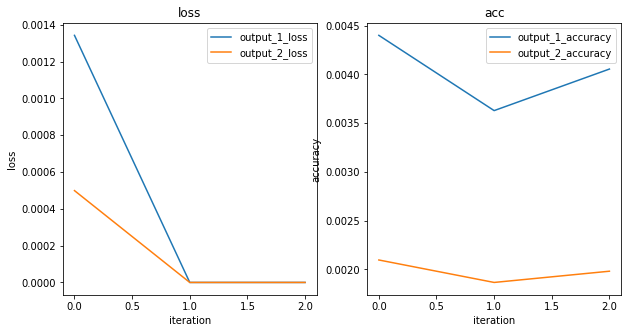

In [32]:
fig, ax = plt.subplots(1, 2, figsize=(10,5))
ax[0].set_title('loss')
ax[0].plot(history.epoch, history.history["output_1_loss"], label="output_1_loss")
ax[0].plot(history.epoch, history.history["output_2_loss"], label="output_2_loss")
ax[0].set_xlabel('iteration')
ax[0].set_ylabel('loss')
ax[0].legend()
ax[1].set_title('acc')
ax[1].plot(history.epoch, history.history["output_1_accuracy"], label="output_1_accuracy")
ax[1].plot(history.epoch, history.history["output_2_accuracy"], label="output_2_accuracy")
ax[1].legend()
ax[1].set_xlabel('iteration')
ax[1].set_ylabel('accuracy')



In [34]:
%mkdir model

In [35]:
model_path = '/content/drive/MyDrive/MyProject/model/'
model.save_pretrained(model_path)
tokenizer.save_pretrained(model_path)

('/content/drive/MyDrive/MyProject/model/tokenizer_config.json',
 '/content/drive/MyDrive/MyProject/model/special_tokens_map.json',
 '/content/drive/MyDrive/MyProject/model/vocab.txt',
 '/content/drive/MyDrive/MyProject/model/added_tokens.json')

**Evaluating**